In [1]:
from MultKAN import *
from utils import *
from spline import *
from scipy.interpolate import make_lsq_spline, BSpline

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchmetrics import Accuracy

torch.set_default_dtype(torch.float64)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
model = KAN(width=[2,5,1], grid=5, k=3, noise_scale=0.3, seed=2)
f = lambda x: torch.exp(torch.sin(torch.pi*x[:,[0]]) + x[:,[1]]**2)
dataset = create_dataset(f, n_var=2)
model.fit(dataset, opt='LBFGS', steps=20, lamb=0.001)
model.plot()

## Related functions (Func2func)

In [3]:
# current_dir = os.path.dirname(__file__)
import warnings
warnings.filterwarnings("ignore")

def points_to_curve(
    y, 
    x=np.array([1/12, 2/12, 3/12, 6/12, 1, 2, 3, 5, 7, 10, 20, 30]), 
    t=[1, 2, 3, 5], 
    k=3
):
    t = np.r_[(x[0],)*(k+1),
            t,
            (x[-1],)*(k+1)]

    spline = make_lsq_spline(x, y, t, k)
    return spline.c

def treasury_data_retrieval(file_name):
    # file_path = os.path.join(current_dir, '..', 'data', file_name)

    df = pd.read_csv(file_name)
    df['Date'] = pd.to_datetime(df['Date'])
    df.sort_values(by='Date', ascending=True, inplace=True)
    df = df.reset_index(drop=True)
    df.set_index('Date', inplace=True)

    return df 

def basis_data_retrieval():
    data = treasury_data_retrieval('us_treasury_rates_large.csv')
    basis = data.apply(points_to_curve, axis=1, result_type="expand")
    basis.columns = [f'Basis_{i}' for i in range(basis.shape[1])]
    return basis

def direct_pred_retrieval():
    data = basis_data_retrieval()

    # data = data.set_index('Date')
    targets = data.columns

    # List of moving average windows
    window_list = [1, 3, 5]

    # List of lags to calculate moving average
    lag_list = [1]

    # List of future date values
    shift_list = [_ for _ in range(20)]

    # Generate future columns
    for shift in shift_list:
        for col in targets:
            data[f'{col}_+_{shift}'] = data[col].shift(-shift)

    # Generate past moving average columns
    for lag in lag_list:
        for window in window_list:
            for col in targets:
                data[f'{col}_-_{lag}_window_{window}'] = data[col].shift(1).rolling(window).mean()
    return data, targets

df = direct_pred_retrieval()[0]
df.head()

,Basis_0,Basis_1,Basis_2,Basis_3,Basis_4,Basis_5,Basis_6,Basis_7,Basis_0_+_0,Basis_1_+_0,...,Basis_6_-_1_window_3,Basis_7_-_1_window_3,Basis_0_-_1_window_5,Basis_1_-_1_window_5,Basis_2_-_1_window_5,Basis_3_-_1_window_5,Basis_4_-_1_window_5,Basis_5_-_1_window_5,Basis_6_-_1_window_5,Basis_7_-_1_window_5
Date,,,,,,,,,,,,,,,,,,,,,
2019-01-02,2.389404,2.456850,2.702452,2.471903,2.439430,2.792307,2.836771,2.969621,2.389404,2.456850,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-03,2.412773,2.433319,2.566584,2.371960,2.308468,2.708715,2.751877,2.919528,2.412773,2.433319,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-04,2.394199,2.477465,2.636133,2.489490,2.430349,2.825259,2.813653,2.979567,2.394199,2.477465,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-07,2.404756,2.521129,2.626514,2.525075,2.475281,2.843453,2.857575,2.989649,2.404756,2.521129,...,2.800767,2.956239,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-08,2.392421,2.537614,2.632026,2.585591,2.534810,2.833007,2.897892,2.999533,2.392421,2.537614,...,2.807702,2.962915,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
def train_mse():
    predictions = model(dataset['train_input'])  # Model predictions
    mse = F.mse_loss(predictions, dataset['train_label'], reduction='mean')  # Compute MSE
    return mse ** 0.5  # Return scalar MSE value

def test_mse():
    predictions = model(dataset['test_input']) # Model predictions
    mse = F.mse_loss(predictions, dataset['test_label'], reduction='mean')  # Compute MSE
    return mse ** 0.5

data, ori_col = direct_pred_retrieval()
all_cols = data.columns
data.tail()

,Basis_0,Basis_1,Basis_2,Basis_3,Basis_4,Basis_5,Basis_6,Basis_7,Basis_0_+_0,Basis_1_+_0,...,Basis_6_-_1_window_3,Basis_7_-_1_window_3,Basis_0_-_1_window_5,Basis_1_-_1_window_5,Basis_2_-_1_window_5,Basis_3_-_1_window_5,Basis_4_-_1_window_5,Basis_5_-_1_window_5,Basis_6_-_1_window_5,Basis_7_-_1_window_5
Date,,,,,,,,,,,,,,,,,,,,,
2024-12-02,4.730691,4.335241,4.337178,4.149289,4.077506,4.137837,4.749234,4.359987,4.730691,4.335241,...,4.798677,4.426317,4.754184,4.418036,4.358609,4.213267,4.166605,4.222166,4.829397,4.465748
2024-12-03,4.644065,4.355321,4.266334,4.162503,4.101351,4.202328,4.775293,4.400051,4.644065,4.355321,...,4.770682,4.386390,4.753191,4.395638,4.345129,4.167141,4.125159,4.171822,4.795556,4.417727
2024-12-04,4.629839,4.337400,4.217692,4.124627,4.059989,4.169103,4.714165,4.350041,4.629839,4.337400,...,4.758351,4.373218,4.732815,4.378099,4.324339,4.161632,4.107473,4.178584,4.784112,4.407798
2024-12-05,4.582256,4.375189,4.186948,4.157661,4.064922,4.126638,4.704006,4.330119,4.582256,4.375189,...,4.746231,4.370026,4.709342,4.360965,4.292260,4.148119,4.083134,4.162000,4.760301,4.381852
2024-12-06,4.560251,4.320623,4.159402,4.102298,4.015630,4.135312,4.677805,4.340107,4.560251,4.320623,...,4.731154,4.360070,4.671040,4.356906,4.261758,4.142358,4.072140,4.149459,4.738645,4.359963


In [21]:
# Out-of-sample test size, diff between sliding element = test size
test_size = 20
sliding_list = range(270, -30, -30)

# Set variables for cross-validation
truth_df = pd.DataFrame()
naive_df = pd.DataFrame()
kan_df = pd.DataFrame()

# Loop over sliding windows
for sliding in sliding_list:
    
    # Trim original data by sliding window size
    df = data[:len(data)-sliding]

    # Use 2 years of data (500 days) for training
    df_train, df_test = df[-test_size-250:-test_size], df[-test_size:]
    len_train = len(df_train)

    # Append to truth dataframe, if multi-step drop iloc
    truth_df = pd.concat([truth_df, df_test[ori_col].iloc[[-1], :]], axis=0, ignore_index=False)

    # Append to naive dataframe, if multi-step change 1 to test_size
    naive_element = pd.DataFrame([df_train[ori_col].iloc[-1].values] * 1)
    naive_df = pd.concat([naive_df, naive_element], axis=0, ignore_index=True)

    # Initialize predictions array
    pred = list()

    # To predict multi-step use range, to predict only h-ahead-step use equal
    # for h in range(test_size):
    for h in [test_size - 1]:
        # Print checkpoints
        print(f'LAST DAY OF DATASET: {-sliding}, FUTURE STEPS: {h+1}')

        # If h = 0 target columns unchanged
        if h == 0:  
            target_col = ori_col
        # If h > 0 target columns modified
        else:       
            target_col = [f'{element}_+_{h}' for element in ori_col]
        
        # Extract feature columns
        feature_col = [element for element in all_cols if 'window' in element]

        # Cut train data due to direct forecast
        df_train_modified = df_train[:(len_train-h)]

        # Test data is the first row 
        df_test_modified = df_test.iloc[[0]]
        print(len(df_train_modified))

        X_train, y_train = df_train_modified[feature_col], df_train_modified[target_col]
        X_test, y_test = df_test_modified[feature_col], df_test.iloc[h][ori_col]

        X_concat = pd.concat([X_train, X_test], axis=0)

        n_inputs = X_train.shape[1]
        n_outputs = y_train.shape[1]

        dataset = dict()
        dtype = torch.get_default_dtype()
        dataset['train_input'] = torch.from_numpy(X_train.values).type(dtype).to(device)
        dataset['train_label'] = torch.from_numpy(y_train.values).type(dtype).to(device)
        dataset['test_input'] = torch.from_numpy(X_test.values).type(dtype).to(device)
        dataset['test_label'] = torch.from_numpy(y_test.values).type(dtype).to(device)

        # Initialize the model
        model = KAN(width=[n_inputs, 32, n_outputs], grid=5, k=2, seed=42, device=device, symbolic_enabled=False, save_act=False, auto_save=False)

        # Train the model and compute metrics
        results = model.fit(dataset, opt="Adam", lr=0.005, steps=500, metrics=(train_mse, test_mse))

        # loss_fn = loss_fn_eval = lambda x, y: torch.mean((x - y) ** 2)
        # p = 
        # train_loss = loss_fn(p, dataset['train_label'])
        # print(train_loss)
        # torch.sqrt(train_loss).cpu().detach().numpy()


        pred.append(model.forward(dataset['test_input']).cpu().detach().numpy().flatten())
        # print(n_inputs, n_outputs)

    kan_element = pd.DataFrame(pred)
    kan_df = pd.concat([kan_element, kan_df], axis=0, ignore_index=True)


import pickle

dataframes = {
    "naive_df": naive_df,
    "kan_df": kan_df,
    "truth_df": truth_df
}

# Specify the file name
filename = f"dfs_{test_size}_steps_ahead.pkl"

# Pickle the DataFrames into a file
with open(filename, "wb") as file:
    pickle.dump(dataframes, file)

print(f"DataFrames have been saved to {filename}")

LAST DAY OF DATASET: -270, FUTURE STEPS: 20
231


| train_loss: 3.37e+00 | test_loss: 3.71e+00 | reg: 0.00e+00 | :   1%| | 4/500 [00:00<00:12, 39.83it

| train_loss: 3.85e-02 | test_loss: 7.19e-01 | reg: 0.00e+00 | : 100%|█| 500/500 [00:09<00:00, 55.34


LAST DAY OF DATASET: -240, FUTURE STEPS: 20
231


| train_loss: 4.32e-02 | test_loss: 6.39e-01 | reg: 0.00e+00 | : 100%|█| 500/500 [00:08<00:00, 56.70


LAST DAY OF DATASET: -210, FUTURE STEPS: 20
231


| train_loss: 4.55e-02 | test_loss: 1.08e+00 | reg: 0.00e+00 | : 100%|█| 500/500 [00:08<00:00, 56.95


LAST DAY OF DATASET: -180, FUTURE STEPS: 20
231


| train_loss: 4.09e-02 | test_loss: 1.01e+00 | reg: 0.00e+00 | : 100%|█| 500/500 [00:08<00:00, 56.11


LAST DAY OF DATASET: -150, FUTURE STEPS: 20
231


| train_loss: 4.09e-02 | test_loss: 9.08e-01 | reg: 0.00e+00 | : 100%|█| 500/500 [00:08<00:00, 56.33


LAST DAY OF DATASET: -120, FUTURE STEPS: 20
231


| train_loss: 3.31e-02 | test_loss: 6.04e-01 | reg: 0.00e+00 | : 100%|█| 500/500 [00:08<00:00, 56.99


LAST DAY OF DATASET: -90, FUTURE STEPS: 20
231


| train_loss: 3.36e-02 | test_loss: 6.66e-01 | reg: 0.00e+00 | : 100%|█| 500/500 [00:08<00:00, 57.38


LAST DAY OF DATASET: -60, FUTURE STEPS: 20
231


| train_loss: 2.84e-02 | test_loss: 8.86e-01 | reg: 0.00e+00 | : 100%|█| 500/500 [00:08<00:00, 56.08


LAST DAY OF DATASET: -30, FUTURE STEPS: 20
231


| train_loss: 2.74e-02 | test_loss: 1.16e+00 | reg: 0.00e+00 | : 100%|█| 500/500 [00:08<00:00, 56.99


LAST DAY OF DATASET: 0, FUTURE STEPS: 20
231


| train_loss: 3.09e-02 | test_loss: 3.81e-01 | reg: 0.00e+00 | : 100%|█| 500/500 [00:08<00:00, 56.14

DataFrames have been saved to dfs_20_steps_ahead.pkl


DataFrames have been saved to dfs_20_steps_ahead.pkl


## Archived experiments

[5.50313067 5.39815988 4.68981464 4.42876501 4.09803712 4.04303337
 4.83939597 4.37999294]
Mean Squared Error: 0.000161


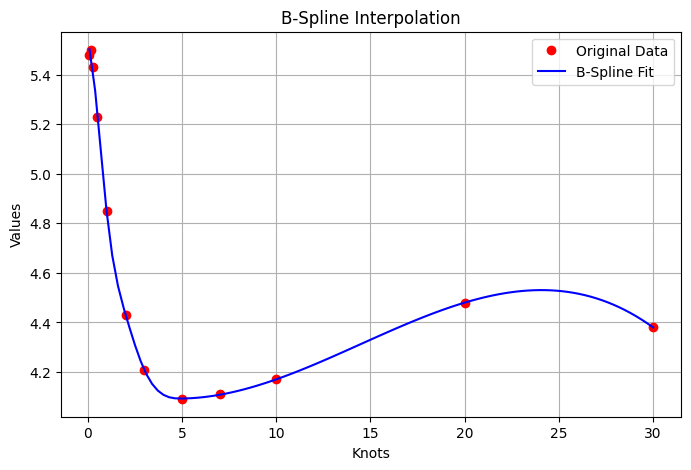

[ 0.08333333  0.16666667  0.25        0.5         1.          2.
  3.          5.          7.         10.         20.         30.        ]
[ 0.08333333  0.08333333  0.08333333  0.08333333  1.          2.
  3.          5.         30.         30.         30.         30.        ]


In [30]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import make_lsq_spline, BSpline
from sklearn.metrics import mean_squared_error

# Assume `data` is a DataFrame with numerical values
data = treasury_data_retrieval('us_treasury_rates_large.csv')

# obj = data.head(1).values.flatten()  # Extract first row as an array
x = np.array([1/12, 2/12, 3/12, 6/12, 1, 2, 3, 5, 7, 10, 20, 30])
y = data.iloc[-100, :].values.flatten()  # Extract first row as an array

# Define knots (assuming `knots` is predefined)
t = [1, 2, 3, 5]
k = 3
t = np.r_[(x[0],)*(k+1),
          t,
          (x[-1],)*(k+1)]
# t = np.r_[(-3, -2, -1, 0), t, (30, 35, 40, 45)]
# print(t)

# # Fit B-Spline
spline = make_lsq_spline(x, y, t, k)
print(spline.c)

y_pred = spline(x)
mse = mean_squared_error(y, y_pred)
print(f'Mean Squared Error: {mse:.6f}')
# print(y)

# if k > 0 and np.any((x < t[k]) | (x > t[-k])): > 1643     raise ValueError('Out of bounds w/ x = %s.' % x)
# Generate smooth values for plotting
x_fine = np.linspace(min(x), max(x), 100)
y_fine = spline(x_fine)  # Evaluate B-spline

# Plot the interpolation
plt.figure(figsize=(8, 5))
plt.plot(x, y, 'ro', label='Original Data')  # Original points
plt.plot(x_fine, y_fine, 'b-', label='B-Spline Fit')  # B-Spline curve
plt.xlabel('Knots')
plt.ylabel('Values')
plt.title('B-Spline Interpolation')
plt.legend()
plt.grid(True)
plt.show()
print(x)
print(t)



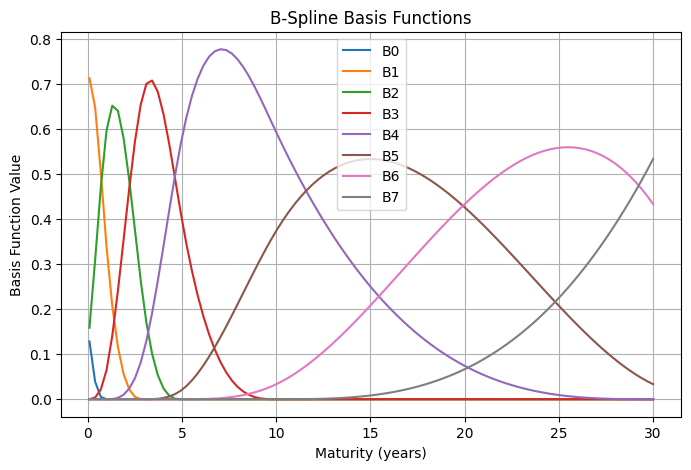

In [17]:
# Plot individual basis functions
plt.figure(figsize=(8, 5))
for i in range(len(t) - k - 1):  # Number of basis functions
    coef = np.zeros(len(t) - k - 1)
    coef[i] = 1.0  # Activate one basis function at a time
    basis_spline = BSpline(t, coef, k)
    plt.plot(x_fine, basis_spline(x_fine), label=f'B{i}')

plt.xlabel('Maturity (years)')
plt.ylabel('Basis Function Value')
plt.title('B-Spline Basis Functions')
plt.legend()
plt.grid(True)
plt.show()

In [42]:
def spline_curve_to_points(
    coef, 
    x = np.array([1/12, 2/12, 3/12, 6/12, 1, 2, 3, 5, 7, 10, 20, 30]), 
    t = [1, 2, 3, 5], 
    k = 3
):
    '''
    Convert spline curve (stored in functional information vector) to discrete points.
    Useful to convert neural network output to same type as discrete truth values to evaluate errors.

    Args:
    -----
        coef: list 
            array of coeffcients corresponding to each basis spline
        x: list
            array of x-axis coordination of discrete points (in this application --> maturities)
        t: list
            array of coordination of knots 
        k: int
            degree of each basis spline

    Returns:
    --------
        y_pred: list
            discrete points extracted from the input spline
    '''
    t = np.r_[(x[0],)*(k+1),
          t,
          (x[-1],)*(k+1)]

    spline = BSpline(t, coef, k)
    y_pred = spline(x)
    return y_pred

coef = spline.c 
x = np.array([1/12, 2/12, 3/12, 6/12, 1, 2, 3, 5, 7, 10, 20, 30])
t = [1, 2, 3, 5]
k = 3 

print(curve_to_points(coef, x, t, k))
print(y)

[5.50313067 5.46897341 5.42483007 5.24855807 4.843396   4.43217539
 4.20762494 4.09287566 4.10806739 4.1703512  4.48002426 4.37999294]
[5.48 5.5  5.43 5.23 4.85 4.43 4.21 4.09 4.11 4.17 4.48 4.38]


In [40]:
def basis_data_retrieval():
    data = treasury_data_retrieval('us_treasury_rates_large.csv')
    basis = data.apply(points_to_curve, axis=1, result_type="expand")
    basis.columns = [f'Basis_{i}' for i in range(basis.shape[1])]
    return basis

test = basis_data_retrieval()
test.head()

,Basis_0,Basis_1,Basis_2,Basis_3,Basis_4,Basis_5,Basis_6,Basis_7
Date,,,,,,,,
2019-01-02,2.389404,2.456850,2.702452,2.471903,2.439430,2.792307,2.836771,2.969621
2019-01-03,2.412773,2.433319,2.566584,2.371960,2.308468,2.708715,2.751877,2.919528
2019-01-04,2.394199,2.477465,2.636133,2.489490,2.430349,2.825259,2.813653,2.979567
2019-01-07,2.404756,2.521129,2.626514,2.525075,2.475281,2.843453,2.857575,2.989649
2019-01-08,2.392421,2.537614,2.632026,2.585591,2.534810,2.833007,2.897892,2.999533


In [43]:
test.apply(spline_curve_to_points, axis=1, result_type='expand')

,0,1,2,3,4,5,6,7,8,9,10,11
Date,,,,,,,,,,,,
2019-01-02,2.389404,2.408933,2.430307,2.499150,2.600942,2.507367,2.454455,2.500820,2.566875,2.650018,2.832109,2.969621
2019-01-03,2.412773,2.419370,2.427645,2.457895,2.501054,2.397387,2.334397,2.378060,2.452758,2.546477,2.752656,2.919528
2019-01-04,2.394199,2.416687,2.438579,2.498383,2.570900,2.507236,2.454764,2.498715,2.570683,2.657859,2.832429,2.979567
2019-01-07,2.404756,2.434879,2.461850,2.525055,2.582579,2.536240,2.496262,2.539156,2.607037,2.690579,2.861958,2.989649
2019-01-08,2.392421,2.429593,2.462126,2.535115,2.599346,2.587204,2.555287,2.586838,2.643526,2.716375,2.882636,2.999533
...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-02,4.730691,4.632349,4.551746,4.397210,4.308409,4.172526,4.102152,4.091315,4.121724,4.191880,4.460011,4.359987
2024-12-03,4.644065,4.571239,4.509532,4.380243,4.274950,4.172658,4.122937,4.121992,4.158615,4.234080,4.499639,4.400051
2024-12-04,4.629839,4.555747,4.492318,4.356006,4.236289,4.132502,4.082834,4.081887,4.119111,4.193726,4.449699,4.350041
